In [1]:
import datetime, scipy 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
#Reading the dataset 
df = pd.read_csv('flights_jun.csv')

In [3]:
#Converting the year month and day columns to datetime objects
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

In [4]:
#Function that formats the time string and convert it to datetime.time
def format_heure(chaine):
    #Keeping the nan values the same
    if pd.isnull(chaine):
        return np.nan
    else:
        #checking if the values lie within the time range
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#Function that combinest the date value and the time value into a single column to create a new datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

In [5]:
#Applying previously defined functions to format the values in the columns
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)
#__________________________________________________________________________
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-06-01 00:10:00,05:00:00,01:42:00,06:37:00,92.0,97.0
1,2015-06-01 00:15:00,06:10:00,00:23:00,06:15:00,8.0,5.0
2,2015-06-01 00:15:00,06:52:00,00:11:00,06:51:00,-4.0,-1.0
3,2015-06-01 00:15:00,06:07:00,00:04:00,05:45:00,-11.0,-22.0
4,2015-06-01 00:15:00,07:45:00,00:17:00,07:48:00,2.0,3.0
5,2015-06-01 00:15:00,05:14:00,00:09:00,05:09:00,-6.0,-5.0


In [6]:
#removing the variables that we won't use
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,NK,LAS,IAH,2015-06-01 00:10:00,01:42:00,92.0,05:00:00,06:37:00,97.0,170.0,175.0
1,AA,SEA,DFW,2015-06-01 00:15:00,00:23:00,8.0,06:10:00,06:15:00,5.0,235.0,232.0
2,DL,ANC,SLC,2015-06-01 00:15:00,00:11:00,-4.0,06:52:00,06:51:00,-1.0,277.0,280.0
3,US,SLC,CLT,2015-06-01 00:15:00,00:04:00,-11.0,06:07:00,05:45:00,-22.0,232.0,221.0
4,F9,LAS,IAD,2015-06-01 00:15:00,00:17:00,2.0,07:45:00,07:48:00,3.0,270.0,271.0


In [7]:
#dropping the rows contiaining Nan values
df.dropna(inplace = True)

In [8]:
#A function to get the statistics of a group of values
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

In [9]:
#Taking the first three weeks of the dataset as the training part of the dataset and the last week for testing the model
df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2015, 6, 23)]
df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2015, 6, 23)]

In [10]:
def get_flight_delays(df, carrier, id_airport, extrem_values = False):
    #Subsetting the dataset for a single airport and a single origin airport
    df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
    # remove extreme delay values which don't help our model in prediction
    if extrem_values:
        df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
        df2.dropna(how = 'any')
    # Conversion: date + heure -> heure
    df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
    df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    #Regrouping the vlues as per the the departure time
    test2 = df2['DEPARTURE_DELAY'].groupby(df2['heure_depart']).apply(get_stats).unstack()
    test2.reset_index(inplace=True)
    #converting the departure time into seconds
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    test2.reset_index(inplace=True)
    test2['heure_depart_min'] = test2['heure_depart'].apply(fct)
    return test2

In [11]:
#Class defined to perform polynomial regression
class fit_polynome:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)

    def split(self, method):        
        self.method = method        
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

        if method == 'all':
            self.X_train = self.X
            self.Y_train = self.Y
            self.X_test  = self.X
            self.Y_test  = self.Y                        
        elif method == 'split':            
            self.X_train, self.X_test, self.Y_train, self.Y_test = \
                train_test_split(self.X, self.Y, test_size=0.3)
    #Function to train the model
    def train(self, pol_order):
        #Setting the order of the regression
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X_train)
        self.regr.fit(self.X_, self.Y_train)
    #Function used to predict values from the testing dataset
    def predict(self, X):
        self.X_ = self.poly.fit_transform(X)
        self.result = self.regr.predict(self.X_)
   #Function that calculates the mean squared error 
    def calc_score(self):        
        X_ = self.poly.fit_transform(self.X_test)
        result = self.regr.predict(X_)
        self.score = metrics.mean_squared_error(result, self.Y_test)

In [12]:
#Taking our airlines as american airlines
carrier = 'AA'
#Taking Philadelphia International Airport as our origin airport
id_airport = 'PHL'

In [13]:
#Subsetting the dataset to only contain one airline and one airport
df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
df2['heure_depart'] = df2['heure_depart'].apply(lambda x:x.hour*3600+x.minute*60+x.second)
test2 = get_flight_delays(df, carrier, id_airport, False)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pa

In [14]:
fit = fit_polynome(test2)

In [15]:
#Creating the dataset for one airline and all airports
def get_merged_delays(df, carrier):
    liste_airports = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    i = 0
    liste_columns = ['AIRPORT_ID', 'heure_depart_min', 'mean']
    for id_airport in liste_airports:
        test2 = get_flight_delays(df, carrier, id_airport, True)
        test2.loc[:, 'AIRPORT_ID'] = id_airport
        test2 = test2[liste_columns]
        test2.dropna(how = 'any', inplace = True)
        if i == 0:
            merged_df = test2.copy()
        else:
            merged_df = pd.concat([merged_df, test2], ignore_index = True)
        i += 1    
    return merged_df

In [16]:
merged_df = get_merged_delays(df, carrier)
merged_df.shape

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

(1913, 3)

In [17]:
#Using label encoder to encode the aiport values
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(merged_df['AIRPORT_ID'])
#__________________________________________________________
# correspondance between the codes and tags of the airports
zipped = zip(integer_encoded, merged_df['AIRPORT_ID'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
#Displaying the first five label encoded values
label_airports[:5]

[(0, 'ABQ'), (1, 'ANC'), (2, 'ATL'), (3, 'AUS'), (4, 'BDL')]

In [18]:
#Using on hot encoder to encode the airport mappings and storing them in a MxM matrix
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
b = np.array(merged_df['heure_depart_min'])
b = b.reshape(len(b),1)
X = np.hstack((onehot_encoded, b))
Y = np.array(merged_df['mean'])
Y = Y.reshape(len(Y), 1)
print(X.shape, Y.shape)

(1913, 79) (1913, 1)


D:\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [19]:
#Performing linear regression
lm = linear_model.LinearRegression()
model = lm.fit(X,Y)
predictions = lm.predict(X)

In [20]:
#Creating a dataset for all the destination airports
def create_df(df, carrier):
    df2 = df[df['AIRLINE'] == carrier][['SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL',
                                    'ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
    df2.dropna(how = 'any', inplace = True)
    df2['weekday'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.weekday())
    #____________________
    # delete delays > 1h
    df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
    df2.dropna(how = 'any', inplace = True)
    #_________________
    # formating times
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    df2['heure_depart'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    df2['heure_depart'] = df2['heure_depart'].apply(fct)
    df2['heure_arrivee'] = df2['SCHEDULED_ARRIVAL'].apply(fct)
    df3 = df2.groupby(['heure_depart', 'heure_arrivee', 'ORIGIN_AIRPORT'],
                      as_index = False).mean()
    return df3

In [21]:
#Regrouping are made on departure and arrival times
df3 = create_df(df, carrier)   

In [22]:
#Using the label encoder to encode the airport names
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df3['ORIGIN_AIRPORT'])
#_________________________________________________________
zipped = zip(integer_encoded, df3['ORIGIN_AIRPORT'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
#Using one hot encoder to map the values of flight paths in a mxm matrix
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#_________________________________________________
b = np.array(df3[['heure_depart', 'heure_arrivee']])
X = np.hstack((onehot_encoded, b))
Y = np.array(df3['DEPARTURE_DELAY'])
Y = Y.reshape(len(Y), 1)

D:\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [23]:
#Seperating the data into tran and test the model to select the best value for alpha
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [24]:
#Running Ridge regression on different values of n and alpha to find out which combination gives us the optimum result
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)
        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)
        
        if score < score_min:
            score_min = score
            parameters = [alpha, pol_order]

        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha/10, score))

n=1 alpha=0.0 , MSE = 39.965
n=1 alpha=0.2 , MSE = 39.421
n=1 alpha=0.4 , MSE = 39.264
n=1 alpha=0.6 , MSE = 39.294
n=1 alpha=0.8 , MSE = 39.416
n=1 alpha=1.0 , MSE = 39.584
n=1 alpha=1.2 , MSE = 39.773
n=1 alpha=1.4 , MSE = 39.969
n=1 alpha=1.6 , MSE = 40.163
n=1 alpha=1.8 , MSE = 40.353


D:\Anaconda\lib\site-packages\sklearn\linear_model\ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


n=2 alpha=0.0 , MSE = 173.45
n=2 alpha=0.2 , MSE = 39.869
n=2 alpha=0.4 , MSE = 39.669
n=2 alpha=0.6 , MSE = 39.551
n=2 alpha=0.8 , MSE = 39.47
n=2 alpha=1.0 , MSE = 39.415
n=2 alpha=1.2 , MSE = 39.381
n=2 alpha=1.4 , MSE = 39.365
n=2 alpha=1.6 , MSE = 39.362
n=2 alpha=1.8 , MSE = 39.372


In [25]:
#Fitting the ridge regressionn fo rthe optimal values of n and alpha
ridgereg = Ridge(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)

45.195917896317404


In [26]:
#Testing the model on january delays
df3 = create_df(df_test, carrier)

In [27]:
#Fitting the model on the testing part of the dataset 
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print('MSE = {}'.format(round(score, 2)))

MSE = 41.74


In [28]:
'Ecart = {:.2f} min'.format(np.sqrt(score))

'Ecart = 6.46 min'

In [29]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in predictions]) 
tips["original_data"] = pd.Series([float(s) for s in Y_test]) 

D:\Anaconda\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


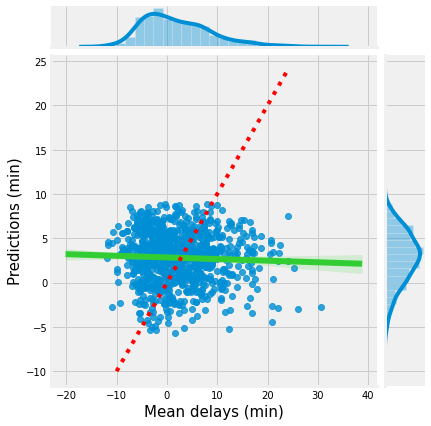

In [30]:
#Plotting a joint plot between the Mean delays and the Predictions
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')

In [31]:
#Running Lasso regression for different values of n and alpha to find the optimal values
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        lassoreg = Lasso(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        lassoreg.fit(X_, Y_train)
        
        X_ = poly.fit_transform(X_test)
        result = lassoreg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)
        
        if score < score_min:
            score_min = score
            parameters = [alpha, pol_order]

        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha/10, score))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if __name__ == '__main__':
D:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
D:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44331.9323101303, tolerance: 10.997695178374672
  positive)


n=1 alpha=0.0 , MSE = 39.963
n=1 alpha=0.2 , MSE = 45.512
n=1 alpha=0.4 , MSE = 45.512
n=1 alpha=0.6 , MSE = 45.512
n=1 alpha=0.8 , MSE = 45.512
n=1 alpha=1.0 , MSE = 45.512
n=1 alpha=1.2 , MSE = 45.512
n=1 alpha=1.4 , MSE = 45.512
n=1 alpha=1.6 , MSE = 45.512
n=1 alpha=1.8 , MSE = 45.512


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if __name__ == '__main__':
D:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
D:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41972.99338601275, tolerance: 10.997695178374672
  positive)


n=2 alpha=0.0 , MSE = 43.195
n=2 alpha=0.2 , MSE = 45.512
n=2 alpha=0.4 , MSE = 45.512
n=2 alpha=0.6 , MSE = 45.512
n=2 alpha=0.8 , MSE = 45.512
n=2 alpha=1.0 , MSE = 45.512
n=2 alpha=1.2 , MSE = 45.512
n=2 alpha=1.4 , MSE = 45.512
n=2 alpha=1.6 , MSE = 45.512
n=2 alpha=1.8 , MSE = 45.512


In [32]:
#Fitting the model for the optimal values of n and alpha
lassoreg = Lasso(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
lassoreg.fit(X_, Y)
result = lassoreg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  """
D:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)


40.41319814330206


D:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62377.77133418674, tolerance: 15.215387486558242
  positive)


In [33]:
X_ = poly.fit_transform(X_test)
result = lassoreg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print('MSE = {}'.format(round(score, 2)))

MSE = 38.29


In [34]:
'Ecart = {:.2f} min'.format(np.sqrt(score))

'Ecart = 6.19 min'

In [35]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in predictions]) 
tips["original_data"] = pd.Series([float(s) for s in Y_test]) 

D:\Anaconda\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


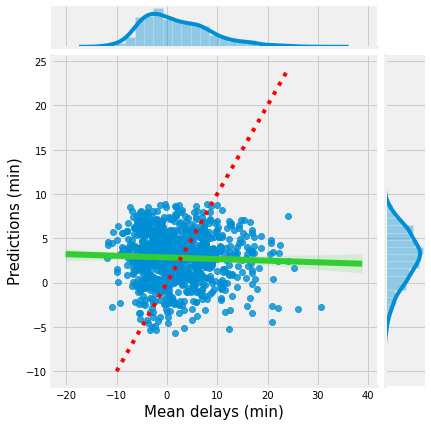

In [36]:
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')